#Toronto ETA Prediction
##by Datalopers
1. Abiyyu Fathin Derian
2. Alifia Cesarina Harmadi
3. Dhea Fajriati Anas
4. Hendri Prabowo
5. Nikolas Rakryan Widagdo


In [ ]:
# mounting gdrive to google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# installing geopandas library
!pip install geopandas

In [ ]:
# importing relevant libraries

import pandas as pd
import geopandas as gpd
import numpy as np
import requests
import shapely
import matplotlib.pyplot as plot
%matplotlib inline

# Reading Inputs

Here, we input Toroto Travel time data for January 2020 to March 2020

In [ ]:
travel_times = pd.read_csv('/content/drive/MyDrive/SupervisedLearningScriptandMaterial/Toronto/Dataset/Travel_Times.csv')
# travel_times_daily = pd.read_csv('/kaggle/input/uber-movement-data/Travel_Times_Daily.csv')
# travel_times_day = pd.read_csv('/kaggle/input/uber-movement-data/Travel_Times_time_of_day.csv')
# travel_times_week = pd.read_csv('/kaggle/input/uber-movement-data/Travel_Times_day_of_week.csv')
toronto_hourly = pd.read_csv('/content/drive/MyDrive/SupervisedLearningScriptandMaterial/Toronto/Dataset/toronto-neighbourhoods-2020-1-All-HourlyAggregate.csv')
# bnglr_wards_weekly = pd.read_csv('/kaggle/input/uber-movement-data/bangalore-wards-2020-1-WeeklyAggregate.csv')
# bnglr_wards_monthly = pd.read_csv('/kaggle/input/uber-movement-data/bangalore-wards-2020-1-All-MonthlyAggregate.csv')

We'll consider the hourly travel time average for modelling.

In [ ]:
toronto_hourly.head(2)

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,33,135,7,2333.88,884.45,2188.31,1.42
1,132,12,7,1095.12,242.96,1068.57,1.25


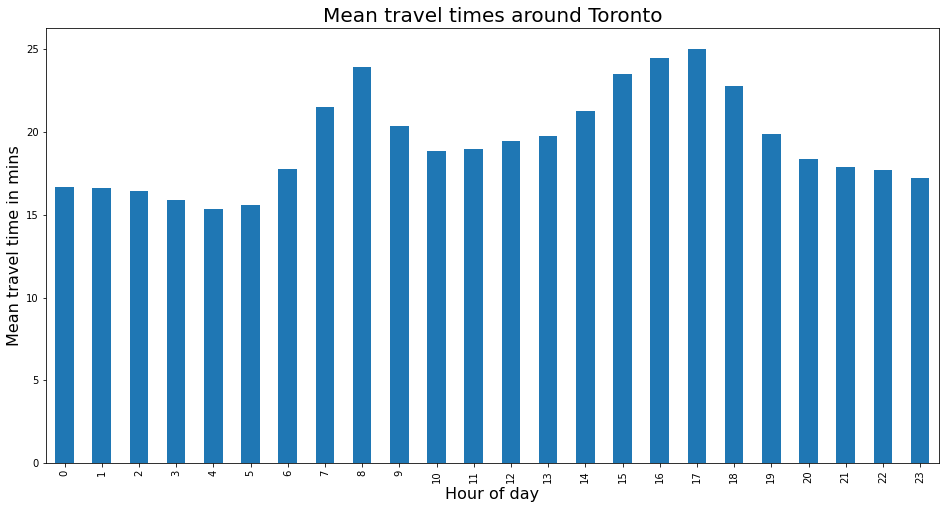

In [ ]:
mean_travel_time_by_hour_of_day = toronto_hourly.groupby('hod')['mean_travel_time'].mean()/60
plt = mean_travel_time_by_hour_of_day.plot(kind="bar", figsize=(16,8))
plt.set_title('Mean travel times around Toronto',fontsize=20)
plt.set_xlabel('Hour of day', fontsize=16)
_ = plt.set_ylabel('Mean travel time in mins', fontsize=16)

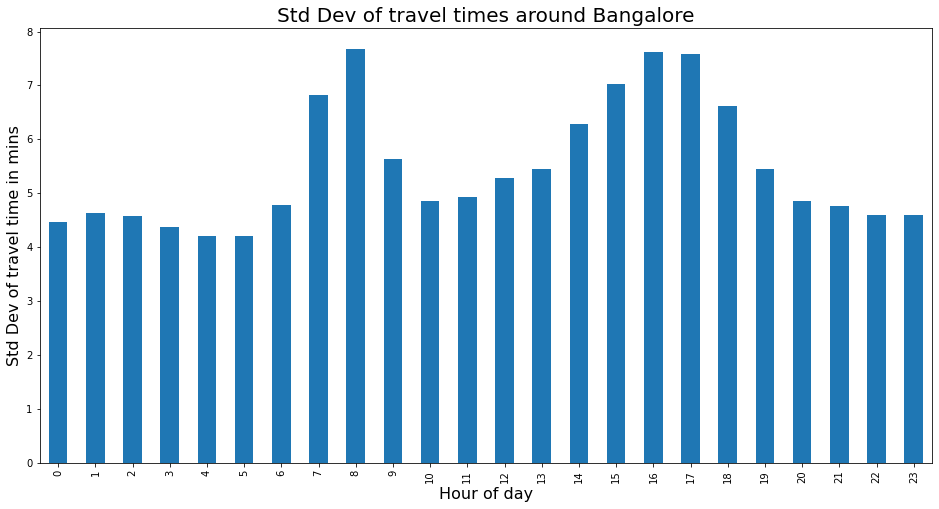

In [ ]:
std_dev_time_by_hour_of_day = toronto_hourly.groupby('hod')['standard_deviation_travel_time'].mean()/60
plt = std_dev_time_by_hour_of_day.plot(kind="bar", figsize=(16,8))
plt.set_title('Std Dev of travel times around Bangalore',fontsize=20)
plt.set_xlabel('Hour of day', fontsize=16)
_ = plt.set_ylabel('Std Dev of travel time in mins', fontsize=16)

# The ward data

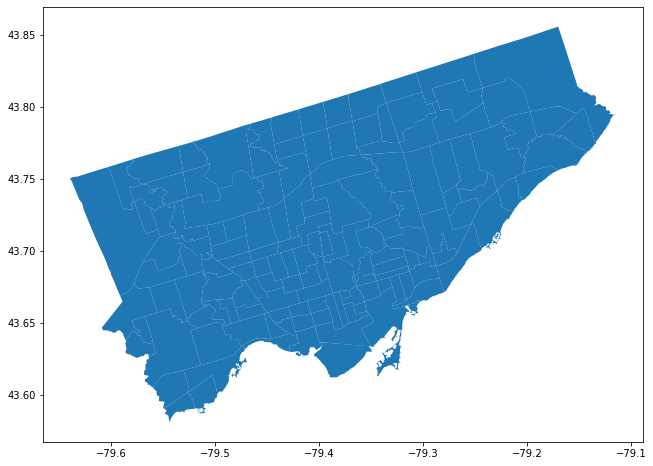

In [ ]:
toronto=gpd.read_file('/content/drive/MyDrive/0projects/IYKRA DATA FELLOWSHIP/Training Phase/7. Supervised Learning++ for predicting ETA using Mobility Data/new_dataset/Toronto_neighbourhoods.json')
toronto.plot(figsize=(16,8))

In [ ]:
toronto.head()

,MOVEMENT_ID,DISPLAY_NAME,geometry
0,1,"York University Busway, York University Height...","MULTIPOLYGON (((-79.50529 43.75987, -79.50488 ..."
1,2,"0 Hambly Avenue, The Beach, Old Toronto, Toronto","MULTIPOLYGON (((-79.31485 43.66674, -79.31356 ..."
2,3,"3400 Kingston Road, Scarborough Village, Scarb...","MULTIPOLYGON (((-79.21397 43.72676, -79.21400 ..."
3,4,"100 Dunn Avenue, Parkdale, Old Toronto, Toronto","MULTIPOLYGON (((-79.42777 43.62979, -79.42948 ..."
4,5,"0 Carlaw Avenue, Leslieville, Old Toronto, Tor...","MULTIPOLYGON (((-79.32868 43.64745, -79.32867 ..."


# Picking centroids to represent an area

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """


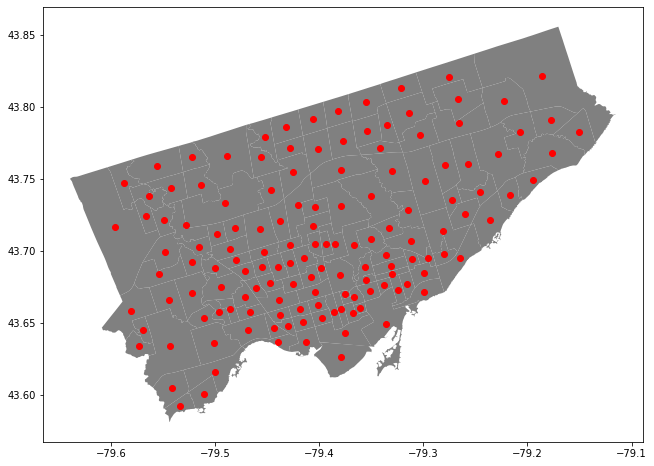

In [ ]:
#toronto = toronto.drop(columns=['WARD_NO', 'MOVEMENT_ID'])

toronto = toronto.drop(columns=['MOVEMENT_ID'])
toronto_c = toronto.copy()
toronto_c.geometry = toronto_c['geometry'].centroid
fig, ax = plot.subplots(figsize=(16,8))
toronto.plot(color='grey',ax=ax)
toronto_c.plot(color='red',ax=ax)

In [ ]:
id_to_dest = travel_times[['Destination Movement ID', 'Destination Display Name']]
id_to_dest.columns = ['id', 'name']
id_to_dest.head()


,id,name
0,1,"York University Busway, York University Height..."
1,2,"0 Hambly Avenue, The Beach, Old Toronto, Toronto"
2,3,"3400 Kingston Road, Scarborough Village, Scarb..."
3,4,"100 Dunn Avenue, Parkdale, Old Toronto, Toronto"
4,5,"0 Carlaw Avenue, Leslieville, Old Toronto, Tor..."


# Get some random points from each ward to diversify representation

In [ ]:
from shapely.geometry import Point
import random

# The number of rows with random points to be created corresponding to each row in source df
number = 3

def random_points_in_polygon(number, polygon):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points

def diversify_geo_data(df):
    new_df = gpd.GeoDataFrame()
    common_columns = df.columns
    common_columns.tolist().remove('geometry')
    for row in df.itertuples():
        points = random_points_in_polygon(number, row.geometry)
        for point in points:
            tmp = gpd.GeoDataFrame(columns=df.columns, data=[list(row[1:2]) + [point]])
            new_df = new_df.append(tmp, ignore_index=True)
    return new_df
            

diversified_points = diversify_geo_data(toronto)
diversified_points.sample(5)

,DISPLAY_NAME,geometry
75,"0 Balmoral Avenue, Midtown Toronto, Old Toront...",POINT (-79.39263 43.68145)
195,"600 Roselawn Avenue, Midtown Toronto, Old Toro...",POINT (-79.42747 43.70235)
276,"0 East Liberty Street, Liberty Village, Old To...",POINT (-79.41169 43.64122)
352,"Yen Lane, Downtown, Old Toronto, Toronto",POINT (-79.36518 43.66803)
324,"1200 Brimley Road, Bendale, Scarborough, Toronto",POINT (-79.25324 43.76616)


In [ ]:
diversified_points.shape

(423, 2)

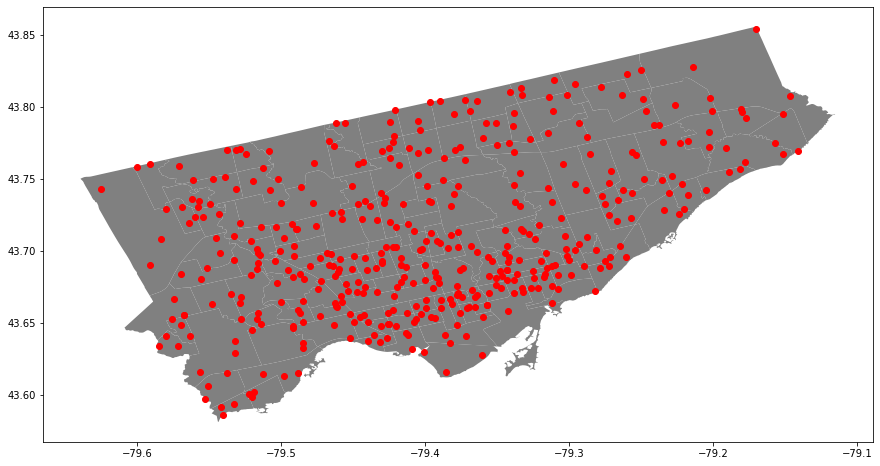

In [ ]:
fig, ax = plot.subplots(figsize=(16,8))
toronto.plot(color='grey',ax=ax)
diversified_points.plot(color='red',ax=ax)

# Cleaning up data for analysis

Got source and destination data and removed unneeded columns like geometric_mean_travel_time and geometric_standard_deviation_travel_time.

In [ ]:
time_df = pd.merge(toronto_hourly, id_to_dest, left_on=['sourceid'], right_on=['id'], how='inner')
time_df = time_df.drop(columns=['id', 'geometric_mean_travel_time', 'geometric_standard_deviation_travel_time'])
time_df = time_df.rename(columns={'name': 'Source Name'})
time_df = pd.merge(time_df, id_to_dest, left_on=['dstid'], right_on=['id'], how='inner')
time_df = time_df.drop(columns=['id'])
time_df = time_df.rename(columns={'name': 'Destination Name'})
time_df = time_df.sort_values(by=['sourceid', 'dstid', 'hod'])
time_df.tail(5)

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,Source Name,Destination Name
279984,141,140,20,1518.76,284.21,"Water's Edge Promenade, Downtown, Old Toronto,...","900 York Beltline Trail, Briar Hill - Belgravi..."
279974,141,140,21,1528.77,300.13,"Water's Edge Promenade, Downtown, Old Toronto,...","900 York Beltline Trail, Briar Hill - Belgravi..."
279980,141,140,22,1481.58,303.79,"Water's Edge Promenade, Downtown, Old Toronto,...","900 York Beltline Trail, Briar Hill - Belgravi..."
279972,141,140,23,1431.77,301.57,"Water's Edge Promenade, Downtown, Old Toronto,...","900 York Beltline Trail, Briar Hill - Belgravi..."
369895,141,141,23,297.76,229.63,"Water's Edge Promenade, Downtown, Old Toronto,...","Water's Edge Promenade, Downtown, Old Toronto,..."


In [ ]:
time_df.shape

(395886, 7)

In [ ]:
toronto_c.shape

(141, 2)

In [ ]:
diversified_points.shape

(423, 2)

In [ ]:
full_toronto = toronto_c.append(diversified_points, ignore_index=True)
full_toronto.shape

(564, 2)

In [ ]:
time_df2 = pd.merge(time_df, full_toronto, left_on=['Source Name'], right_on=['DISPLAY_NAME'], how='inner')
time_df2 = time_df2.drop(columns=['DISPLAY_NAME'])
time_df2 = time_df2.rename(columns = {'WARD_NAME': 'Source Ward Name', 'geometry': 'Source Geometry'})
time_df2 = pd.merge(time_df2, full_toronto, left_on=['Destination Name'], right_on=['DISPLAY_NAME'], how='inner')
time_df2 = time_df2.drop(columns=['DISPLAY_NAME'])
time_df2 = time_df2.rename(columns = {'WARD_NAME': 'Destination Ward Name', 'geometry': 'Destination Geometry'})
time_df2.sample(3)

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,Source Name,Destination Name,Source Geometry,Destination Geometry
5672629,67,130,11,1509.44,357.31,"100 Donald Avenue, Silverthorn, York, Toronto","400 Lawrence Avenue East, Scarborough, Toronto",POINT (-79.46391 43.68902),POINT (-79.38185 43.73079)
204324,44,7,2,1267.29,237.51,"200 Johnston Avenue, Lansing, North York, Toronto","2800 Kingston Road, Cliffcrest, Scarborough, T...",POINT (-79.42405 43.76442),POINT (-79.23553 43.72112)
379430,117,12,20,1567.99,408.39,"300 Passmore Avenue, Armdale, Scarborough, Tor...","100 Isabella Street, Downtown, Old Toronto, To...",POINT (-79.25951 43.82260),POINT (-79.37408 43.66761)


In [ ]:
time_df2.shape

(6334176, 9)

In [ ]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

import os.path
def file_exists(filename):
    return os.path.exists(filename)

input_path = '/content/drive/MyDrive/0projects/IYKRA DATA FELLOWSHIP/Training Phase/7. Supervised Learning++ for predicting ETA using Mobility Data/new_dataset/output/'

# Calculating distances to use as a feature

In [ ]:
import geopy.distance

def calc_distance(x):
    src_point = (x['Source Geometry'].y, x['Source Geometry'].x)
    dest_point = (x['Destination Geometry'].y, x['Destination Geometry'].x)
    return geopy.distance.geodesic(src_point, dest_point).kilometers

filename = 'Df_for_modelling.bin'
path = input_path + filename

#print(file_exists(path))

if file_exists(path):
    # skip to next section since the results here are already precalculated
    pass
else:
    print('Creating distance file')
    time_df2['Geodesic Distance'] = time_df2.apply(func = calc_distance, axis=1)
    df = time_df2


In [ ]:
filename = 'Df_for_modelling.bin'
path = input_path + filename
if file_exists(path):
    with open(path, 'rb') as file:
        final_df = pickle.load(file)
else:
    print('Creating final df file')
    final_df = df.copy()
    final_df['Source lat'] = final_df['Source Geometry'].apply(lambda pt: float(pt.y))
    final_df['Source long'] = final_df['Source Geometry'].apply(lambda pt: float(pt.x))
    final_df['Dest lat'] = final_df['Destination Geometry'].apply(lambda pt: float(pt.y))
    final_df['Dest long'] = final_df['Destination Geometry'].apply(lambda pt: float(pt.x))

    
features = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'hod', 'Geodesic Distance']
outcome = ['mean_travel_time']
final_df = final_df[features + outcome]

try:
    save_object(final_df, input_path + filename)
except:
    pass

# Modelling

## XGBoost

Model without eval set


In [ ]:

X = final_df[features]
y = final_df[outcome]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)


In [ ]:

import xgboost as xgb

filename = 'XGB_model_5.bin'
path = input_path + filename
if file_exists(path):
    with open(path, 'rb') as file:
        my_model = pickle.load(file)
else:
    #my_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, n_jobs=4, objective='reg:squarederror')
    #my_model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.125, n_jobs=4, objective='reg:squarederror')
    my_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.083, n_jobs=4, objective='reg:squarederror')
    my_model.fit(X_train, y_train,verbose=False)
    
try:    
    save_object(X_train, 'train_set_x.bin')
    save_object(y_train, 'train_set_y.bin')
    save_object(X_test, 'test_set_x.bin')
    save_object(y_test, 'test_set_y.bin')
    save_object(my_model, input_path + filename)
except:
    pass

In [ ]:
save_object(X_train, 'train_set_x.bin')
save_object(y_train, 'train_set_y.bin')
save_object(X_test, 'test_set_x.bin')
save_object(y_test, 'test_set_y.bin')

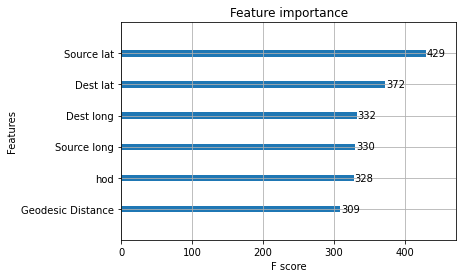

In [ ]:
xgb.plot_importance(my_model)

Note: the travel time is in seconds, so as we see below, the error is pretty low.

In [ ]:
predictions = my_model.predict(X_train)

from sklearn import metrics

r2 = metrics.r2_score(y_train, predictions)
print('R2: {}\n'.format(r2))

mse = metrics.mean_squared_error(y_train, predictions)
print('MSE: {}\n'.format(mse))

print('RMSE: {}\n'.format(np.sqrt(mse)))

mae = metrics.mean_absolute_error(y_train, predictions)
print('MAE: {}\n'.format(mae))

R2: 0.8144112286016941

MSE: 53018.6563680756

RMSE: 230.2578041415222

MAE: 177.96039231292502



In [ ]:
predictions = my_model.predict(X_test)

from sklearn import metrics

r2 = metrics.r2_score(y_test, predictions)
print('R2: {}\n'.format(r2))

mse = metrics.mean_squared_error(y_test, predictions)
print('MSE: {}\n'.format(mse))

print('RMSE: {}\n'.format(np.sqrt(mse)))

mae = metrics.mean_absolute_error(y_test, predictions)
print('MAE: {}\n'.format(mae))


R2: 0.8142916301326019

MSE: 53069.07395099708

RMSE: 230.3672588520276

MAE: 178.0341882767593



/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


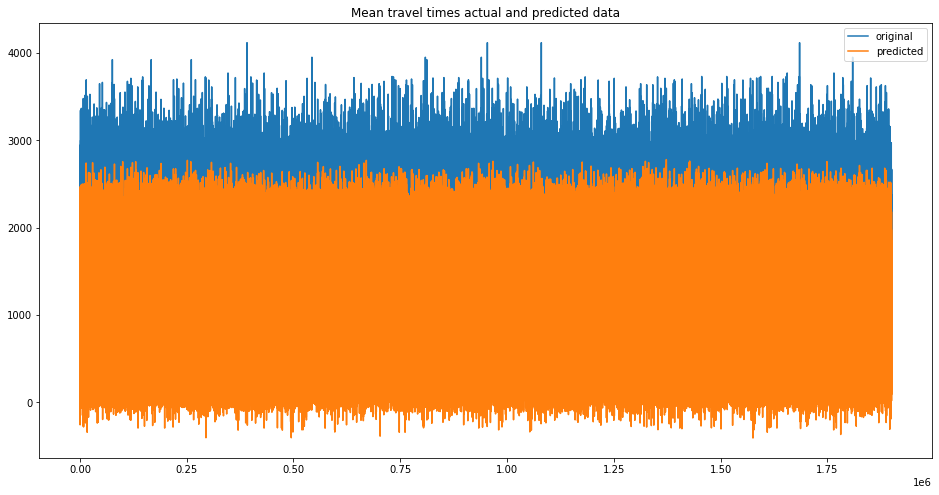

In [ ]:
plot.figure(figsize = (16, 8))
x_ax = range(len(y_test))
plot.plot(x_ax, y_test, label="original")
plot.plot(x_ax, predictions, label="predicted")

plot.title("Mean travel times actual and predicted data")

plot.legend()
plot.show()

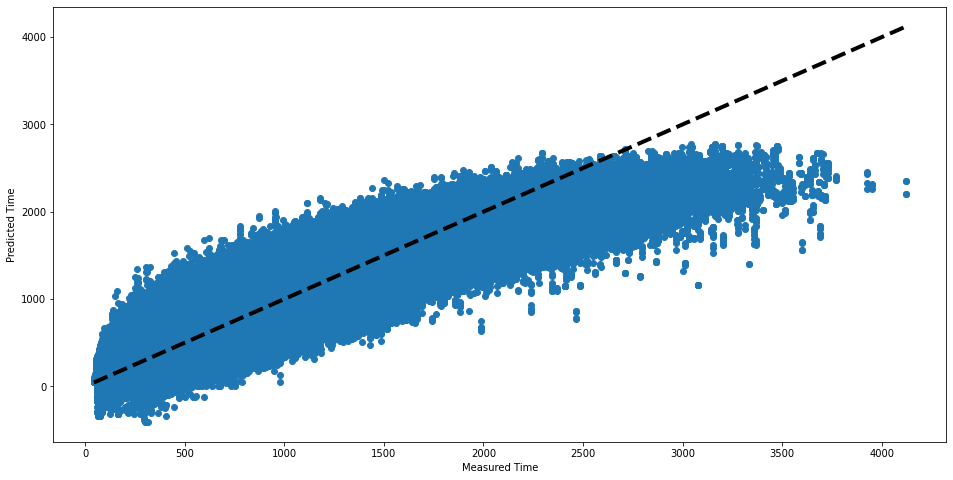

In [ ]:
fig, ax = plot.subplots(figsize=(16,8))
ax.scatter(y_test, predictions)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured Time')
ax.set_ylabel('Predicted Time')
plot.show()

In [ ]:
from sklearn.model_selection import cross_val_score, KFold

score = my_model.score(X_train, y_train)  
print("Training score: ", score)

# These take more than 9 hours to complete so skipped

# scores = cross_val_score(my_model, X_train, y_train, cv=10)
# print("Mean cross-validation score: %.2f" % scores.mean())

# kfold = KFold(n_splits=10, shuffle=True)
# kf_cv_scores = cross_val_score(my_model, X_train, y_train, cv=kfold )
# print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

Training score:  0.8144112286016941


### Testing with some random points

In [ ]:
features = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'hod', 'Geodesic Distance']
outcome = ['mean_travel_time']

def get_distance(lat1, long1, lat2, long2):
    src_point = (lat1, long1)
    dest_point = (lat2, long2)
    return geopy.distance.geodesic(src_point, dest_point).kilometers

def prepare_df(lat1, long1, lat2, long2, hod):
    distance = get_distance(lat1, long1, lat2, long2)
    return pd.DataFrame(columns = ['Source lat', 'Source long', 'Dest lat', 'Dest long', 'hod', 'Geodesic Distance'],
                 data = [[lat1, long1, lat2, long2, hod, distance]])
    
def predict(df):
    return my_model.predict(df[features])

In [ ]:
def compare(actual, predicted):
#     actual = [act[0] for act in actual[outcome].values.tolist()]
#     predicted = predicted.tolist()
    return pd.DataFrame(data = {'actual': actual, 'prediction': predicted})


In [ ]:
# entire bangalore geojson from https://github.com/datameet/PincodeBoundary/tree/master/Bangalore

# bangalore_polygon = gpd.read_file('../input/external-geodata/bangalore boundary.geojson')
# bangalore_polygon.plot()

In [ ]:
def get_random_points_in_bangalore(number):
    points = []
    min_x, min_y, max_x, max_y = 12.85, 77.45, 13.0, 77.75  
    i= 0
    while i < number:
        point = (random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        i += 1
        points.append(point)
    return points

# ORS_API_KEY = '5b3ce3597851110001cf6248f4d0d79bab0a4f5a8b95a4403ba8b839'

# def get_ORS_data(source, dest):
#     parameters = {
#         'locations' : [['{},{}'.format(source[1], source[0])],['{},{}'.format(dest[1], dest[0])]]
#     }
#     headers = {'Authorization ': ORS_API_KEY}
#     response = requests.post(
#         'https://api.openrouteservice.org/v2/matrix/driving-car', data=parameters, headers=headers)

#     if response.status_code == 200:
#         print('Request successful.')
#         data = response.json()
#         summary = data['features'][0]['properties']['summary']
#         print(summary)
# #         distance = summary['distance']/1000
#         return duration
#     else:
#         print('Request failed.')
#         print(response.text)

In [ ]:
# get_ORS_data((12.928781971722811, 77.6121303701099), (12.854079170010449, 77.55145104575789))

In [ ]:
# points1 = get_random_points_in_bangalore(10)
# points2 = get_random_points_in_bangalore(10)

# travel_times_ORS = []
# for point1, point2 in zip(points1, points2):
#     travel_times_ORS.append(get_ORS_data(point1, point2))
    
# travel_times_model = []
# for point1, point2 in zip(points1, points2):
#     lat1, long1, lat2, long2 = point1[0], point1[1], point2[0], point2[1]
#     hod = random.uniform(0, 23)
#     p = predict(prepare_df(lat1, long1, lat2, long2, hod))
#     p = p.tolist()[0]
#     travel_times_model.append(p)
    
# print({points: time for points, time in zip(zip(points1, points2), travel_times_model)})
# compare(travel_times_ORS, travel_times_model)

In [ ]:
points = [((12.999289603200602, 77.72750046509455),
  (12.900586869608652, 77.57751972070913)),
 ((12.935917259525278, 77.61353555551875),
  (12.856440148061886, 77.48546536718554)),
 ((12.897459477917653, 77.7095308106631),
  (12.996842230621631, 77.64938231715406)),
 ((12.936661694778596, 77.71873838420447),
  (12.907286088453898, 77.4772158363428)),
 ((12.88453533783865, 77.70914845848147),
  (12.893719016027402, 77.71748845762684)),
 ((12.90661849980788, 77.6359030720415),
  (12.986913454190185, 77.6667791482254)),
 ((12.89600641097292, 77.70444731327966),
  (12.98987526206819, 77.60524558740501)),
 ((12.897523292566822, 77.56067149766076),
  (12.894608188894253, 77.66337661025209)),
 ((12.86194623889842, 77.56338966329798),
  (12.944443289052925, 77.4887976744094)),
 ((12.858621405573748, 77.46556646993612),
  (12.90990445061544, 77.58937083560666))]

hours_of_day = [18, 7, 18, 2, 16, 23, 10, 8, 4, 16]

In [ ]:
# taking average of thetime bounds given by manual google maps travel times for same coordinates and departure time
travel_times_gmaps_in_mins = [75, 55, 43, 63, 7, 45, 60, 50, 40, 50]
travel_times_gmaps = [t*60 for t in travel_times_gmaps_in_mins]

In [ ]:
travel_times_model = []
points1 = [p[0] for p in points]
points2 = [p[1] for p in points]
for point1, point2, hod in zip(points1, points2, hours_of_day):
    lat1, long1, lat2, long2 = point1[0], point1[1], point2[0], point2[1]
    p = predict(prepare_df(lat1, long1, lat2, long2, hod))
    p = p.tolist()[0]
    travel_times_model.append(p)
[t/60 for t in travel_times_model]

[25.990226236979165,
 19.91377156575521,
 21.361116536458333,
 23.14827677408854,
 3.259459686279297,
 12.927237955729167,
 18.379241943359375,
 19.07325642903646,
 13.768043009440104,
 24.47551066080729]

In [ ]:
compare(travel_times_gmaps, travel_times_model)

,actual,prediction
0,4500,1559.413574
1,3300,1194.826294
2,2580,1281.666992
3,3780,1388.896606
4,420,195.567581
5,2700,775.634277
6,3600,1102.754517
7,3000,1144.395386
8,2400,826.082581
9,3000,1468.530640


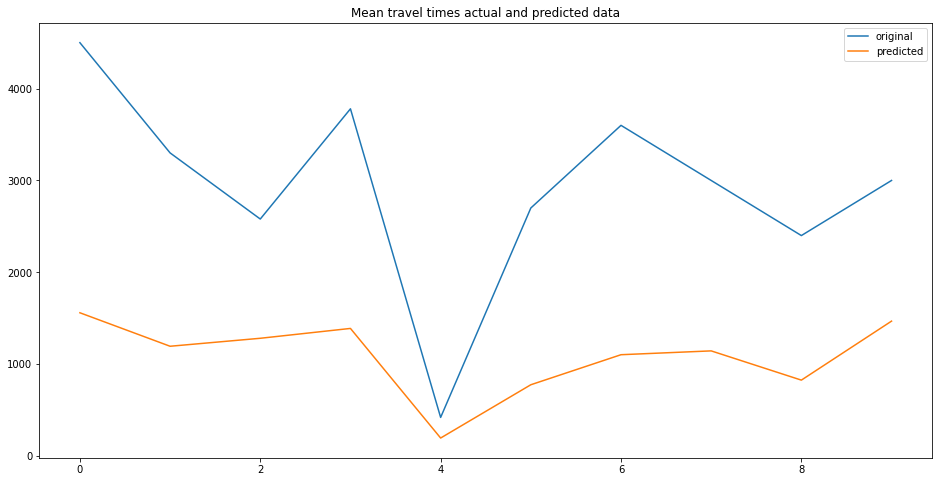

In [ ]:
plot.figure(figsize=(16,8))
x_ax = range(len(travel_times_model))
plot.plot(x_ax, travel_times_gmaps, label="original")
plot.plot(x_ax, travel_times_model, label="predicted")

plot.title("Mean travel times actual and predicted data")

plot.legend()
plot.show()

### Live testing

In [ ]:
lat1 = 13.002385
long1 = 77.568491
lat2 = 13.061071
long2 = 77.597371
hod = 10

df = prepare_df(lat1, long1, lat2, long2, hod)
predict(df)

array([623.11755], dtype=float32)

## Lightgbm

In [ ]:
import lightgbm as lgb

filename = 'LightGBM_model_5.bin'
path = input_path + filename
if file_exists(path):
    with open(path, 'rb') as file:
        model = pickle.load(file)
else:
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test)

    params = {
      'boosting_type': 'gbdt',
      'metric': 'rmse',
      'objective': 'regression',
      'n_jobs': -1,
      'seed': 236,
      'learning_rate': 0.05,
      'bagging_fraction': 0.75,
      'bagging_freq': 10, 
      'colsample_bytree': 0.75}

    model = lgb.train(params, lgb_train, num_boost_round=2500, early_stopping_rounds=100, valid_sets = [lgb_train, lgb_eval], verbose_eval=100)
try:    
    save_object(model, input_path + filename)
except:
    pass

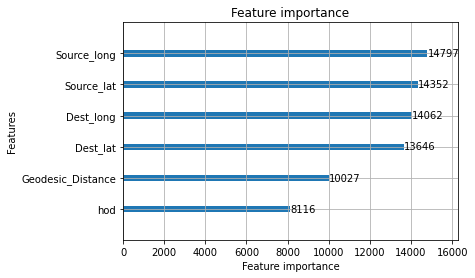

In [ ]:
lgb.plot_importance(model)

Note: the travel time is in seconds, so as we see below, the error is pretty low.

In [ ]:
predictions = model.predict(X_train)

from sklearn import metrics

r2 = metrics.r2_score(y_train, predictions)
print('R2: {}\n'.format(r2))

mse = metrics.mean_squared_error(y_train, predictions)
print('MSE: {}\n'.format(mse))

print('RMSE: {}\n'.format(np.sqrt(mse)))

mae = metrics.mean_absolute_error(y_train, predictions)
print('MAE: {}\n'.format(mae))

R2: 0.9484179875424467

MSE: 14735.853751579816

RMSE: 121.39132486129236

MAE: 90.28884819006086



In [ ]:
predictions = model.predict(X_test)

from sklearn import metrics

r2 = metrics.r2_score(y_test, predictions)
print('R2: {}\n'.format(r2))

mse = metrics.mean_squared_error(y_test, predictions)
print('MSE: {}\n'.format(mse))

print('RMSE: {}\n'.format(np.sqrt(mse)))

mae = metrics.mean_absolute_error(y_test, predictions)
print('MAE: {}\n'.format(mae))

R2: 0.9480914366469917

MSE: 14833.684605803128

RMSE: 121.79361479898331

MAE: 90.56814584464905



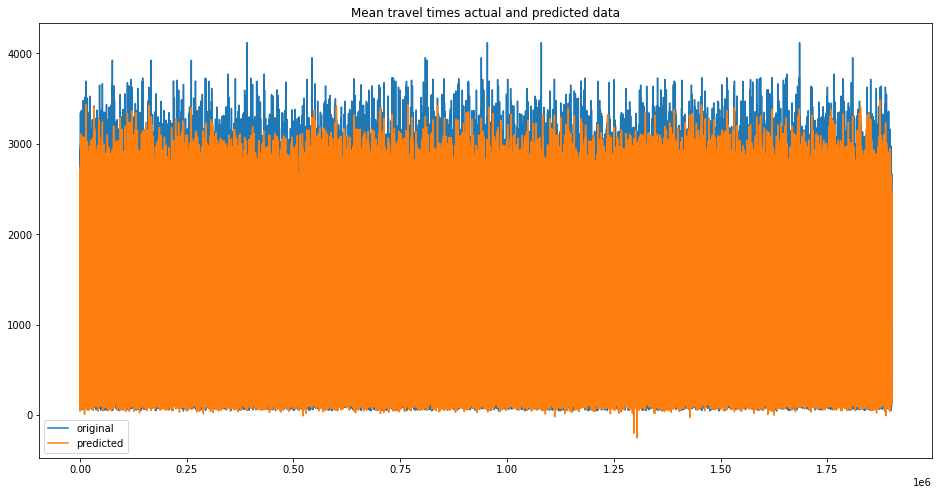

In [ ]:
plot.figure(figsize = (16, 8))
x_ax = range(len(y_test))
plot.plot(x_ax, y_test, label="original")
plot.plot(x_ax, predictions, label="predicted")

plot.title("Mean travel times actual and predicted data")

plot.legend()
plot.show()

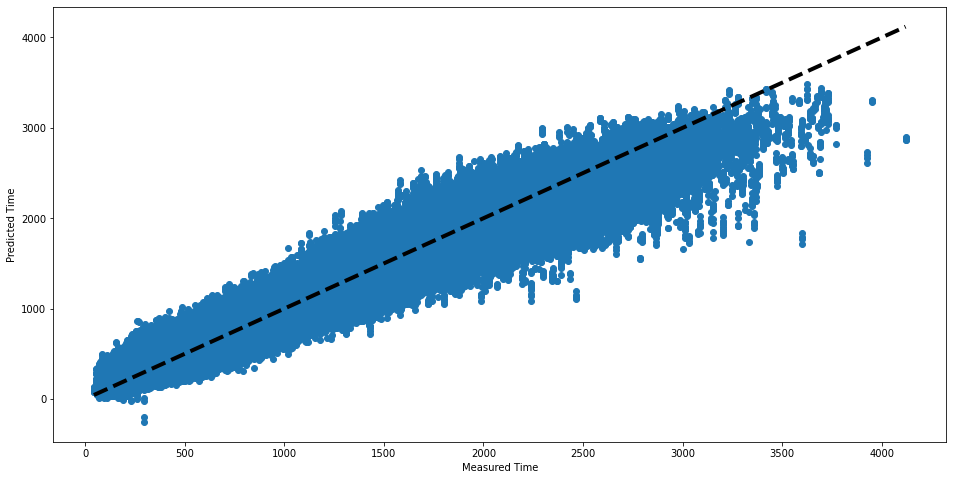

In [ ]:
fig, ax = plot.subplots(figsize = (16, 8))
ax.scatter(y_test, predictions)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured Time')
ax.set_ylabel('Predicted Time')
plot.show()

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

filename = 'KNN_model_5.bin'
path = input_path + filename
if file_exists(path):
    with open(path, 'rb') as file:
        my_model1 = pickle.load(file)
else:
    my_model1 = KNeighborsRegressor(n_neighbors=10)
    my_model1.fit(X_train, y_train)
    
try:    
    save_object(my_model1, input_path + filename)
except:
    pass

In [ ]:
predictions = my_model1.predict(X_train)

from sklearn import metrics

r2 = metrics.r2_score(y_train, predictions)
print('R2: {}\n'.format(r2))

mse = metrics.mean_squared_error(y_train, predictions)
print('MSE: {}\n'.format(mse))

print('RMSE: {}\n'.format(np.sqrt(mse)))

mae = metrics.mean_absolute_error(y_train, predictions)
print('MAE: {}\n'.format(mae))

R2: 0.8686729834415274

MSE: 37517.25877755226

RMSE: 193.69372415633984

MAE: 147.6347117902136



In [ ]:
predictions = my_model1.predict(X_test)

from sklearn import metrics

r2 = metrics.r2_score(y_test, predictions)
print('R2: {}\n'.format(r2))

mse = metrics.mean_squared_error(y_test, predictions)
print('MSE: {}\n'.format(mse))

print('RMSE: {}\n'.format(np.sqrt(mse)))

mae = metrics.mean_absolute_error(y_test, predictions)
print('MAE: {}\n'.format(mae))


R2: 0.8363944117577196

MSE: 46752.858082947314

RMSE: 216.22409228147384

MAE: 164.89411278603436



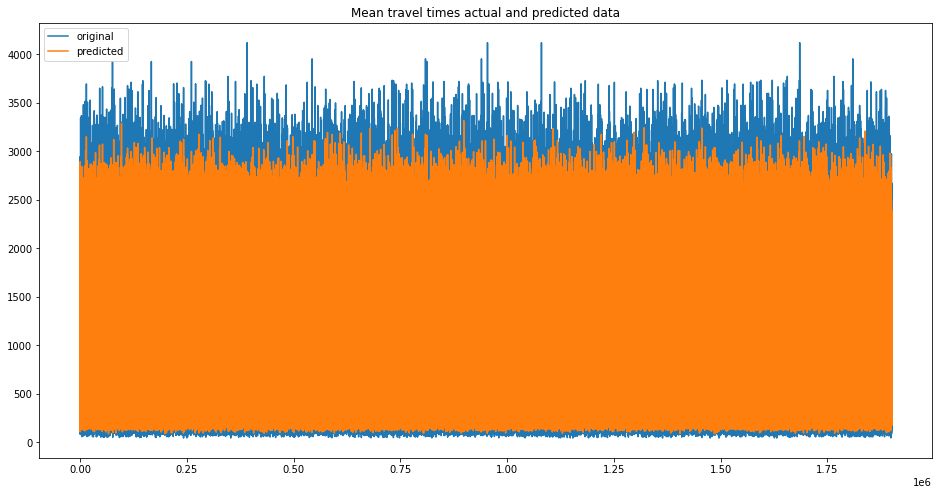

In [ ]:
plot.figure(figsize = (16, 8))
x_ax = range(len(y_test))
plot.plot(x_ax, y_test, label="original")
plot.plot(x_ax, predictions, label="predicted")

plot.title("Mean travel times actual and predicted data")

plot.legend()
plot.show()

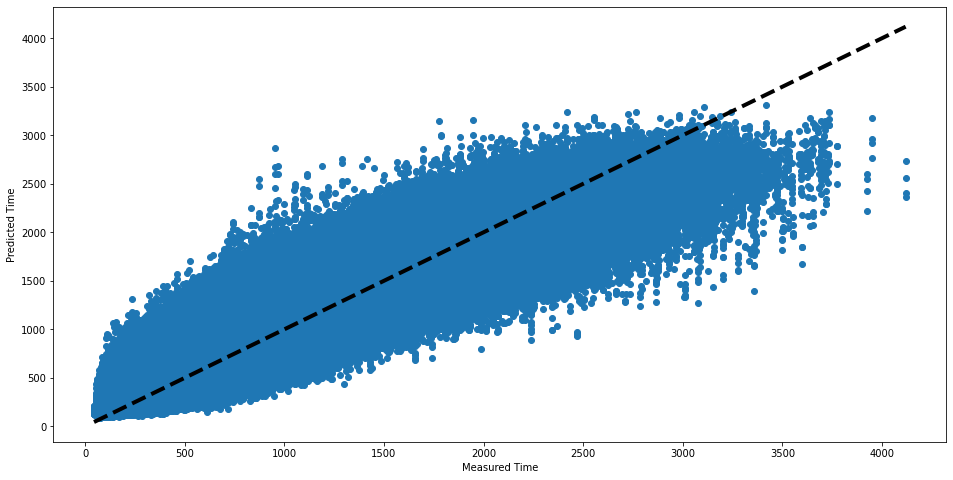

In [ ]:
fig, ax = plot.subplots(figsize = (16, 8))
ax.scatter(y_test, predictions)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured Time')
ax.set_ylabel('Predicted Time')
plot.show()